# Performance Profiling

In this notebook, we analyze the output from log files created from `performance_profiling_tsm.py`. This:
1. baseline (current state of the code)


For each we do a `basic profile` and `detailed profile`:
* `basic`: tests 1, 10, 1000, 10000, and 100000 iterations with combinations of 1, 1000, and 10000 length xarrays
* `detailed`: tests one specific profile (if timed out)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def basic_plot(df):
    fig, ax = plt.subplots()

    for key, grp in df.groupby('iters'):
        ax.plot(grp['gridsize'], grp['avg_increment_time'], marker='o', linestyle='-', label=f'iters={key}')

    ax.set_xscale('log')
    ax.set_ylim(0,0.5)
    ax.legend()
    ax.set_xlabel('Gridsize')
    ax.set_ylabel('Average Increment Time')
    ax.set_title('Average Increment Time vs Gridsize for Different Iterations')

    plt.show()

In [3]:
def detailed_plot(df):
    fig, ax1 = plt.subplots()

    # Plot timesteps vs time_per_iter on the first y-axis
    ax1.plot(df.timestep, df.time_per_iter, 'b-', marker='o', linestyle='-',)
    ax1.set_xlabel('Timesteps')
    ax1.set_ylabel('Time per iteration (s)', color='b')
    ax1.tick_params('y', colors='b')

    # Create a second y-axis and plot MB on it
    ax2 = ax1.twinx()
    ax2.plot(df.timestep, df.MB, 'r-', marker='o', linestyle='-',)
    ax2.set_ylabel('Memory (MB)', color='r')
    ax2.tick_params('y', colors='r')

    plt.title('Timesteps vs Time per iteration and Memory')
    plt.show()

## Baseline

### Basic Profile

I ran the basic profile overnight, and it basically "timed out" at the 10,000 iteration; 10,000 cell scenario. Let's analyze those results:

In [4]:
bs = pd.read_csv(
    '../temp/performance_profiling/baseline.log'
)
bs

,2024-03-07 10:47:44,187,INFO,iters,gridsize,avg_increment_time,total_increment_time
0,2024-03-07 10:47:53,45,INFO,1,1,8.827869,8.858390
1,2024-03-07 10:47:59,529,INFO,1,1000,6.453110,6.484367
2,2024-03-07 10:47:59,577,INFO,1,10000,0.031167,0.047167
3,2024-03-07 10:47:59,904,INFO,10,1,0.029659,0.327740
4,2024-03-07 10:48:00,154,INFO,10,1000,0.023437,0.249992
5,2024-03-07 10:48:00,514,INFO,10,10000,0.032811,0.359344
6,2024-03-07 10:48:03,436,INFO,100,1,0.028906,2.922309
7,2024-03-07 10:48:06,92,INFO,100,1000,0.026252,2.656401
8,2024-03-07 10:48:11,124,INFO,100,10000,0.050163,5.031664
9,2024-03-07 10:48:39,313,INFO,1000,1,0.028158,28.188817


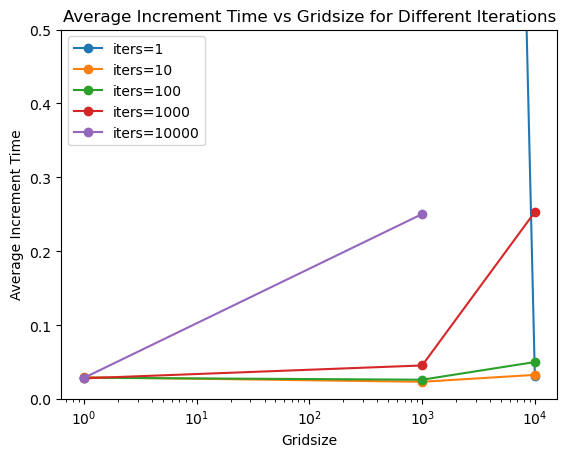

In [5]:
basic_plot(bs)

With a grid size of just one cell, we see that the largest number of iterations is actually fastest, I think due to the `numba` / no-numba discussion. However, as the grid size increases, we see there are points at which the time per increment really takes off. 10,000 iterations and 1,000 cells takes about as much time per timestep as 10,000 grid cells at 1,000 timesteps; beyond this, the testing script was aborted because it had been running the entire night without output for 10,000 time steps and 10,000 grid cells-- >12 hours for <10,000 timesteps is over 4 seconds/timestep.

`iters=1` is slowest per timestep, I think due to the compilation step at the beginning that has some expense. 

## Detailed Profiling

Now, we dive into the point at which this failed. We run the log output of just the 10,000 iteration and 10,000 cell test case for our more detailed profiling, which calculates the seconds per iteration at every 100 timesteps to get a better sense of what is going on. This ran all day and did not complete, but we can plot the results to get a sense of where we're failing:

In [8]:
bs_detailed = pd.read_csv(
    '../temp/performance_profiling/baseline_10000_10000_detailed_profile.log'
)
bs_detailed

,2024-02-23 09:44:06,538,INFO,timestep,MB,time_per_iter
0,2024-02-23 09:44:25,42,INFO,100,197.940408,0.184442
1,2024-02-23 09:44:42,155,INFO,200,389.940808,0.171134
2,2024-02-23 09:45:06,811,INFO,300,581.941208,0.246557
3,2024-02-23 09:45:34,771,INFO,400,773.941608,0.279599
4,2024-02-23 09:46:09,324,INFO,500,965.942008,0.345536
...,...,...,...,...,...,...
64,2024-02-23 14:44:01,265,INFO,6500,12485.966008,5.004906
65,2024-02-23 15:02:13,643,INFO,6600,12677.966408,10.923542
66,2024-02-23 15:48:13,83,INFO,6700,12869.966808,27.593644
67,2024-02-23 16:24:55,606,INFO,6800,13061.967208,22.024890


C:\Users\sjordan\AppData\Local\Temp\ipykernel_23972\2534518291.py:5: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "b-" (-> linestyle='-'). The keyword argument will take precedence.
  ax1.plot(df.timestep, df.time_per_iter, 'b-', marker='o', linestyle='-',)
C:\Users\sjordan\AppData\Local\Temp\ipykernel_23972\2534518291.py:12: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "r-" (-> linestyle='-'). The keyword argument will take precedence.
  ax2.plot(df.timestep, df.MB, 'r-', marker='o', linestyle='-',)


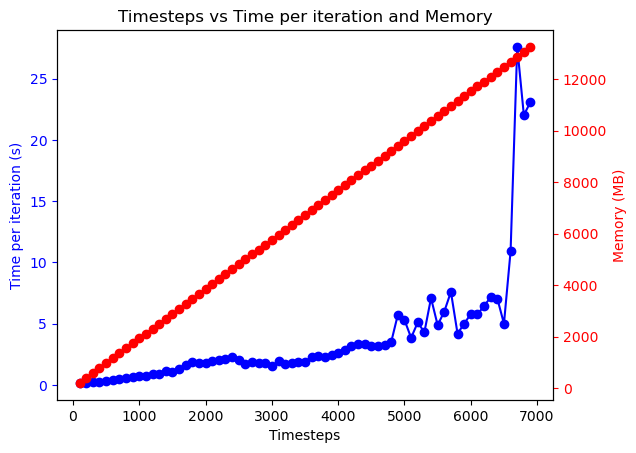

In [9]:
detailed_plot(bs_detailed)

The first thing we can see is that there's a massive spike in time per iteration as we approach 7,000 iterations. Memory steadily increases with each timestep, increasing from 0 MB to 12,000 MB (12 GB).  

## Pre-Init and Tracking Dynamic Variables

The last comparion was not entirely fair, because we weren't properly tracking dynamic variables correctly. This gives us some sense of where we'll be once we improve memory management. 

In [6]:
dv = pd.read_csv(
    '../temp/performance_profiling/track_dynamic.log'
)
dv.head()

,2024-03-07 07:35:41,094,INFO,iters,gridsize,avg_increment_time,total_increment_time
0,2024-03-07 07:35:51,156,INFO,1,1,9.999879,10.061755
1,2024-03-07 07:35:58,421,INFO,1,1000,7.218679,7.265549
2,2024-03-07 07:35:58,515,INFO,1,10000,0.046973,0.093844
3,2024-03-07 07:35:59,171,INFO,10,1,0.059338,0.656213
4,2024-03-07 07:35:59,624,INFO,10,1000,0.040624,0.453094


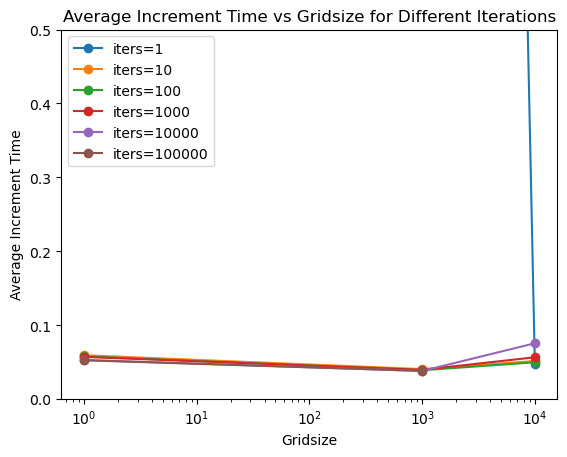

In [10]:
basic_plot(dv)

0
1
2
3
4
5
0
1
2
3
4


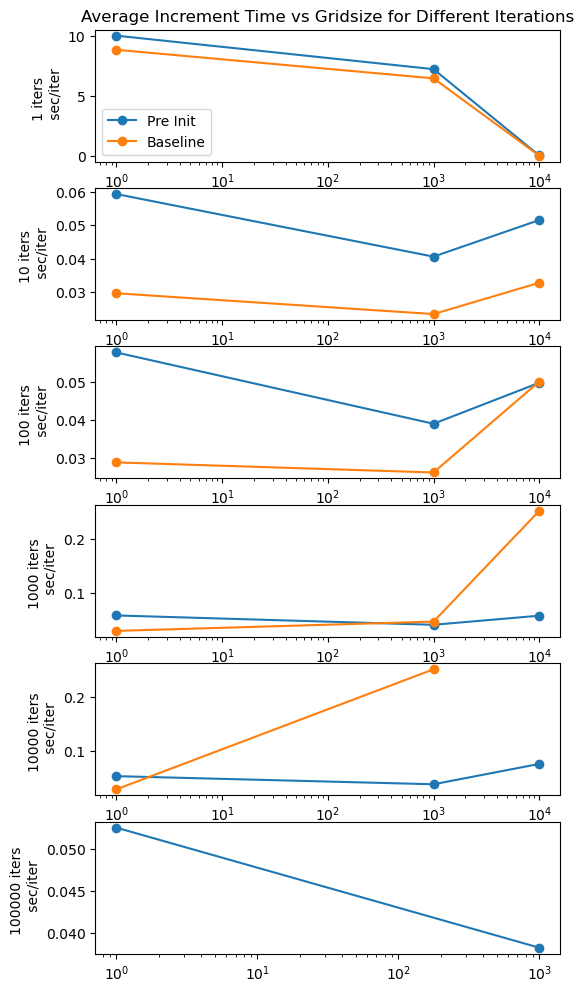

In [12]:
fig, axs = plt.subplots(6,1)

n=0
for key, grp in dv.groupby('iters'):
    print(n)
    axs[n].plot(grp['gridsize'], grp['avg_increment_time'], marker='o', linestyle='-', label=f'Pre Init')
    n+=1
n=0
for key, grp in bs.groupby('iters'):
    print(n)
    axs[n].plot(grp['gridsize'], grp['avg_increment_time'], marker='o', linestyle='-', label=f'Baseline')
    n+=1

vals = dv.iters.unique()
i = 0
for ax in axs:
    ax.set_xscale('log')
    if i == 0:
        ax.set_title('Average Increment Time vs Gridsize for Different Iterations')
        ax.legend()
    if i == 6:
        ax.set_xlabel('Gridsize')
    ax.set_ylabel(f"{vals[i]} iters \n sec/iter")
    i+=1
fig.set_size_inches(6, 12)

plt.show()

This is pretty interesting. The pre-init is slower with just one grid cell across all examples (perhaps due to increased memory up front), but is faster once the memory issues really take hold (1,000 iterations or more) and can make it much further in the simulation (100,000 iters and 1,000 grid cells); though it does max out of memory for 100,000 timesteps and 100,000 grid cells.

After doing some performance profiling, it appears that setting items in the array takes up the most time. Let's see if it's faster to make a copy of a single slice, do the work on it, and then put it in our xarray.